# FAST-UAV - Uncertainty analysis
*Author: Félix Pollet - 2023* <br>

The purpose of this notebook is to run uncertainty analyses in order to evaluate the impacts of models uncertainty and input parameters uncertainty.

The user is referred to the following publication for further details:
> F. Pollet, M. Budinger, S. Delbecq, J. -M. Moschetta, and J. Liscouët. Quantifying and Mitigating Uncertainties in Design Optimization Including Off-the-Shelf Components: Application to an Electric Multirotor UAV. Aerospace Science and Technology, 2023, pp.108179. https://doi.org/10.1016/j.ast.2023.108179.


## 1. Setting up the UAV model

In a first place, we define in the configuration file the UAV model that will be used to run the analyses. Here, no optimization of the design is carried out, i.e. we start from an existing design and analyse its performance on a given mission.

In [1]:
# Import required librairies
import os.path as pth
import openmdao.api as om
import logging
import warnings
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
from fastuav.utils.postprocessing.sensitivity_analysis.sensitivity_analysis import (
    morris_analysis,
    sobol_analysis,
)

# Declare paths to folders and files
DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")
warnings.filterwarnings(action="ignore")

# For using all screen width
from IPython.display import display, HTML, IFrame
display(HTML("<style>.container { width:95% !important; }</style>"))

Let's start by defining the multidisciplinary analysis (MDA). The [MDA](https://websites.isae-supaero.fr/IMG/pdf/2016_mca_martins_mdo_course_slides.pdf) consists of evaluating the model while solving the coupled equations.<br>
With a Normalized Variable Hybrid (NVH) formulation as adopted in FAST-UAV, the MDA is carried out by the optimizer instead of a dedicated solver. The optimizer is responsible for solving the consistency constraints, that is the coupled states of the system. For more information about the consistency constraints please refer to Delbecq et al. article available [here](https://oatao.univ-toulouse.fr/26691/).

In [2]:
# MDA Problem
CONFIGURATION_FILE_MDA = pth.join(WORK_FOLDER_PATH, "configuration.yaml")
oad.generate_configuration_file(
    CONFIGURATION_FILE_MDA, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mda.yaml"  # you can modify the model in this file, e.g. add off-the-shelf components
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\configuration.yaml'

In [3]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE_MDA, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

## 2. Deterministic reference
We now load an existing UAV design on which the uncertainty analysis will be run. Here, the source file correspond to the *deterministic* results obtained from a prior design optimization. This *deterministic* design will be considered as a reference.

In [5]:
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")  # the deterministic results are used as a reference
oad.variable_viewer(SOURCE_FILE)

To make sure that the source file is consistent with the problem definition and the models, an MDA is carried out. No difference between the values of the source file and the output values of the problem should be observed.<br>

In [6]:
INPUT_FILE = oad.generate_inputs(CONFIGURATION_FILE_MDA, SOURCE_FILE, overwrite=True)
problem = oad.optimize_problem(
    CONFIGURATION_FILE_MDA, overwrite=True
)  # Run MDA
REFERENCE_DESIGN_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
oad.variable_viewer(REFERENCE_DESIGN_FILE)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5423052397159918
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization Complete
-----------------------------------


## 3. Uncertainty analysis

In contrast with a single problem evaluation, the uncertainty analysis relies on multiple evaluations of the problem to analyse the effects of varying one or several parameters on the output variables of interest.

The [OpenTurns](https://openturns.github.io/openturns/latest/index.html) and [SALib](https://salib.readthedocs.io/en/latest/index.html) libraries are used to set up the design of experiements and run the sensitivity analyses. 
The drivers to connect these librairies to FAST-UAV are provided by Onera's [OpenMDAO Extensions](https://github.com/OneraHub/openmdao_extensions).

### 3.1 Screening procedure - Morris method

The Morris method allows to get a measure of importance and interaction of input factors. It is used as a screening method to reduce the number of parameters prior to a more detailed analysis.

The `morris_analysis` function takes the following inputs:
- The configuration file of the problem to be evaluated;
- The source file containing the reference design, to help the user to set up the analysis (uncertain parameters selection, output variable of interest, ...). 

The number of simulation runs required are $r(k+1)$ where $r$ is the number of trajectories (typically between 4 to 10) and $k$ the number of parameters.

**Bibliography**

> Ruano, M.V., Ribes, J., Seco, A., Ferrer, J., 2012. An improved sampling strategy based on trajectory design for application of the Morris method to systems with many input factors. Environmental Modelling & Software 37, 103–109. https://doi.org/10.1016/j.envsoft.2012.03.008

> Morris, M.D., 1991. Factorial Sampling Plans for Preliminary Computational Experiments. Technometrics 33, 161–174. https://doi.org/10.1080/00401706.1991.10484804

> Campolongo, F., Cariboni, J., Saltelli, A., 2007. An effective screening design for sensitivity analysis of large models. Environmental Modelling & Software, Modelling, computer-assisted simulations, and mapping of dangerous phenomena for hazard assessment 22, 1509–1518. https://doi.org/10.1016/j.envsoft.2006.10.004


In [7]:
morris_analysis(CONFIGURATION_FILE_MDA, REFERENCE_DESIGN_FILE)

    'data': [{'error_y': {'array': [], 'type': 'data'},
         …

### 3.2 Global sensitivity analysis - Sobol' indices using Saltelli's sampling scheme

The Sobol' method allows to get a representation of the contribution of the inputs to the overall uncertainty in the model output. The space of the uncertain inputs is explored with a Monte Carlo sampling (here Saltelli's scheme, which extends the Sobol' sequence in a way to reduce the error rates in the resulting sensitivity index calculations).

The number of simulation runs required are $m(k+2)$ where $m$ is the number of samples (typically between 100s to 1000s) and $k$ the number of parameters. It is therefore recommanded to run the Sobol' method on the reduced set of parameters identified as the most important ones with the previous method of Morris.

**Bibliography**

> Campolongo, F., Saltelli, A., Cariboni, J., 2011. From screening to quantitative sensitivity analysis. A unified approach. Computer Physics Communications 182, 978–988. https://doi.org/10.1016/j.cpc.2010.12.039

> Saltelli, A., 2002. Making best use of model evaluations to compute sensitivity indices. Computer Physics Communications 145, 280–297. https://doi.org/10.1016/S0010-4655(02)00280-1

> Sobol’, I.M., 2001. Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates. Mathematics and Computers in Simulation, The Second IMACS Seminar on Monte Carlo Methods 55, 271–280. https://doi.org/10.1016/S0378-4754(00)00270-6


In [8]:
sobol_analysis(CONFIGURATION_FILE_MDA, REFERENCE_DESIGN_FILE)

    'data': [{'error_y': {'array': [], 'type': 'data'},
         …

## 4. Dev/Expert mode

*Advanced analyses and plots*.

You may reuse data from the DoEs ran with `morris_analysis` and `sobol_analysis` methods to display custom plots or run new analyses.

In [3]:
import pandas as pd
from scipy.stats import norm, describe
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams.update({"font.size": 15, "lines.markersize": 10, "figure.figsize": [12, 6]})
SA_PATH = "./workdir/sensitivity_analysis"

### Morris analysis and plots

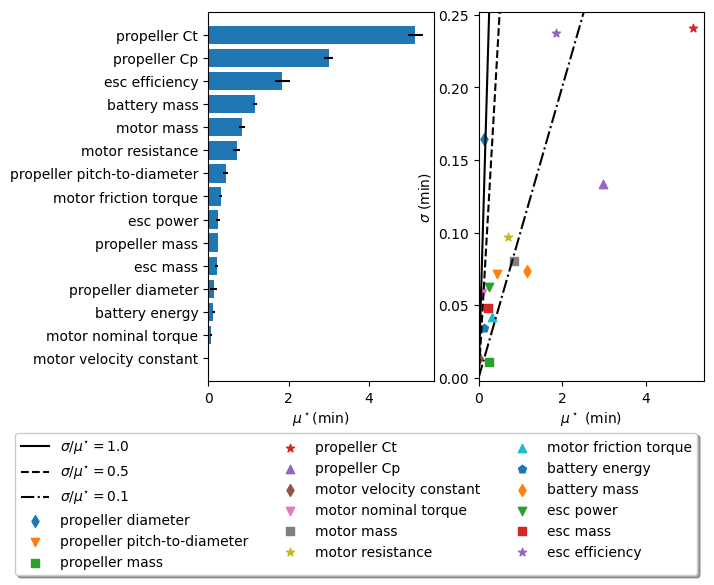

In [4]:
# MORRIS METHOD
from fastuav.utils.postprocessing.sensitivity_analysis.morris_plot import morris_plot
from SALib.analyze import morris

# Load DoE csv file
df_morris = pd.read_csv(SA_PATH + "/doe_Morris.csv", sep=",")

# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_morris.txt", "r")  # if you want to customize the variables' names, modify them in the problem_morris.txt file directly.
f_inputs = open(SA_PATH + "/x_morris.txt", "r")
f_output = open(SA_PATH + "/y_morris.txt", "r")
problem = eval(f_problem.read())
x = eval(f_inputs.read())
y = f_output.read()
f_problem.close()
f_inputs.close()
f_output.close()

# Read data
X = df_morris[x].to_numpy()
Y = df_morris[y].to_numpy()

# Run Morris analysis with SALib
Si = morris.analyze(problem, X, Y, print_to_console=False, conf_level=0.95, num_resamples=100)

# Plot results
fig = morris_plot(Si, unit="(min)")

# Save figure
plt.savefig(SA_PATH + "/figures/morris_plot.pdf", bbox_inches="tight", dpi=1200)

### Sobol' analysis and plot

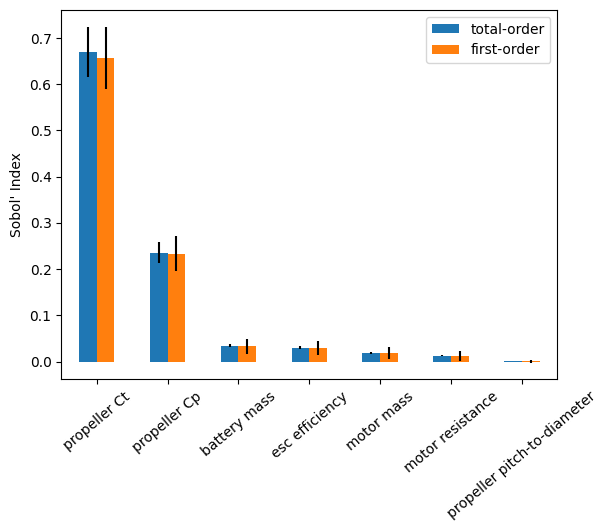

In [5]:
# SOBOL' METHOD
from fastuav.utils.postprocessing.sensitivity_analysis.sobol_plot import sobol_plot
from SALib.analyze import sobol

# Load DoE csv file
df_sobol = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")

# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_sobol.txt", "r")
f_output = open(SA_PATH + "/y_sobol.txt", "r")
problem = eval(f_problem.read())
y = f_output.read()
f_problem.close()
f_output.close()

# Read data
Y = df_sobol[y].to_numpy()

# Run Sobol analysis with SALib
Si = sobol.analyze(problem, Y, calc_second_order=True)

# Plot results
ax = sobol_plot(Si)
ax.tick_params(axis="x", labelrotation=40)
plt.savefig(SA_PATH + "/figures/sobol_plot.pdf", bbox_inches="tight")

### Single output distribution

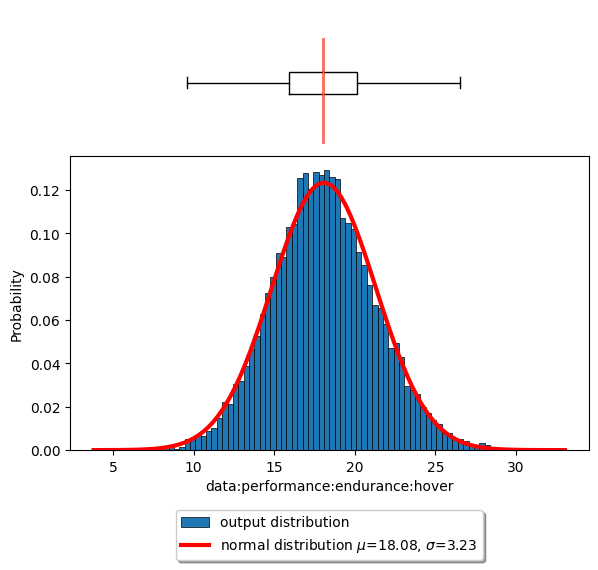

In [6]:
# Single output distribution
from fastuav.utils.postprocessing.sensitivity_analysis.distribution_plot import hist_dist_plot

# Import data of DoE
df_output = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")

# Select variable to display
y = 'data:performance:endurance:hover'
# y = 'data:weight:mtow'

# Plot histogram of distribution
fig = hist_dist_plot(df_output, y)

# Save figure
plt.savefig(SA_PATH + "/figures/output_dist.pdf", bbox_inches="tight")

In [7]:
# Compute several descriptive statistics of the Monte Carlo output
describe(df_output[y])

DescribeResult(nobs=16384, minmax=(5.131390973987654, 31.701498431239187), mean=18.076413403665526, variance=10.44213463660897, skewness=0.13729059254793274, kurtosis=0.23988729337370573)

### Results from multiple DoE
In this figure, the results from one or several design of experiments are ploted in a 2-D plot. The associated distributions are also provided.

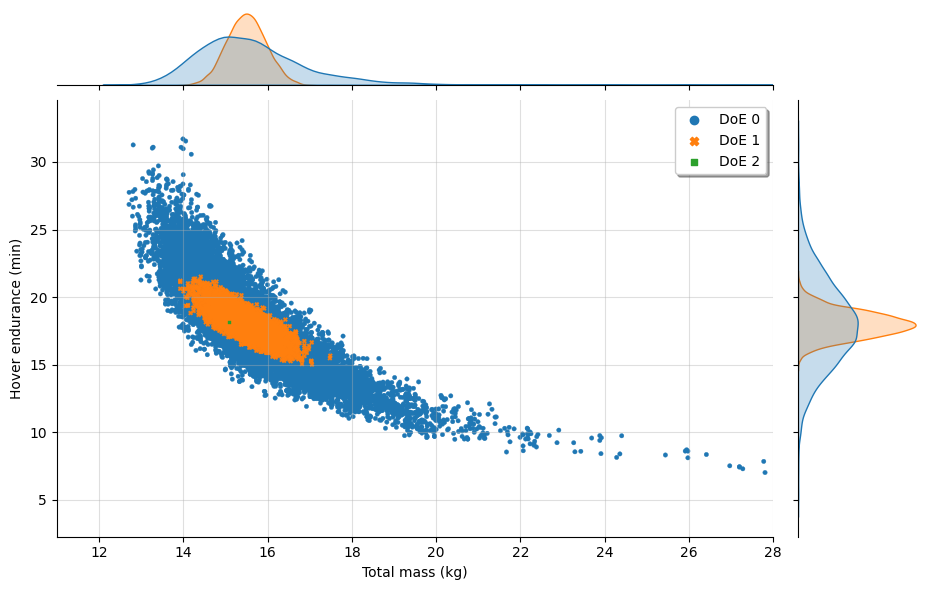

In [8]:
# DoE plots
from fastuav.utils.postprocessing.sensitivity_analysis.distribution_plot import DoE_plot

# Import data
df_1 = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
df_2 = pd.read_csv(SA_PATH + "/doe_Sobol_2.csv", sep=",")
df_3 = pd.DataFrame({'data:weight:mtow': [15.1], 'data:performance:endurance:hover': [18.1]})
df_array = [df_1, df_2, df_3]

# Select two variables to display
x = 'data:weight:mtow'
y = 'data:performance:endurance:hover'

# Plot results
g = DoE_plot(df_array, x, y)

# Modify a few plot parameters
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
plt.xlim([11, 28])
plt.xlabel("Total mass (kg)");
plt.ylabel("Hover endurance (min)");
lgnd = plt.legend(ncol=1, fancybox=True, shadow=True)
plt.grid(alpha=0.4)

# Save figure
plt.savefig(SA_PATH + "/figures/output_dist_combined_twoaxes.pdf", bbox_inches="tight")

### Monte Carlo convergence

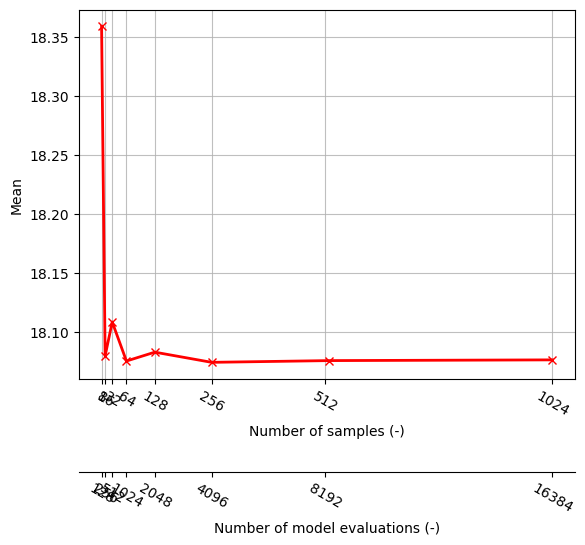

In [9]:
# CONVERGENCE OF OUTPUT'S DISTRIBUTION MEAN
from fastuav.utils.postprocessing.sensitivity_analysis.doe_convergence_plot import mean_convergence

# Number of samples used in Sobol method
n_array = np.asarray([8, 16, 32, 64, 128, 256, 521, 1024])

# Number of uncertain parameters in DoE
d = 7

# Whether second order indices have been calculated or not
second_order = True

# Results for each DoE
mu_array = np.asarray([18.3594188845527, 18.07972086, 18.10854741, 18.07542507, 18.08295194, 18.07432445, 18.07580122, 18.0764134])
std_array = np.asarray([3.4372846, 3.265402024, 3.402328383, 3.211321973, 3.254410035, 3.218580434, 3.218400047, 3.231429194])
# mu_conf_array = 1.96 * std_array / np.sqrt(n_sim_array)

# Plot
fig, ax = mean_convergence(n_array, mu_array, d, second_order)

# Save figure
plt.savefig(SA_PATH + "/figures/MC_convergence_1.pdf", bbox_inches="tight")

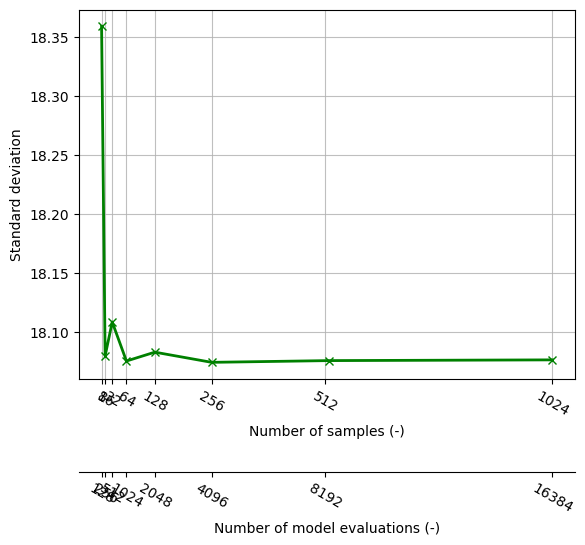

In [10]:
# CONVERGENCE OF OUTPUT'S DISTRIBUTION STANDARD DEVIATION
from fastuav.utils.postprocessing.sensitivity_analysis.doe_convergence_plot import std_convergence

# Plot
fig, ax = std_convergence(n_array, mu_array, d, second_order)

# Save figure
plt.savefig(SA_PATH + "/figures/MC_convergence_2.pdf", bbox_inches="tight")

### Sobol' indices convergence

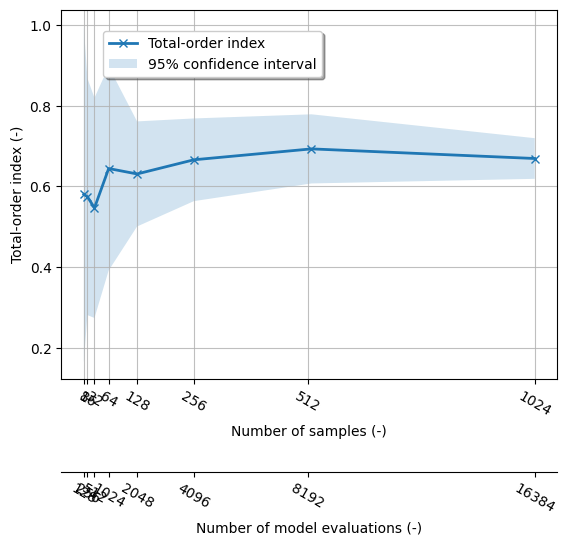

In [11]:
# SOBOL' INDICES CONVERGENCE
from fastuav.utils.postprocessing.sensitivity_analysis.doe_convergence_plot import sobol_index_convergence

# Number of samples
n_array = np.asarray([8, 16, 32, 64, 128, 256, 521, 1024])

# Number of uncertain parameters in DoE
d = 7

# Whether second order indices have been calculated or not
second_order = True

# Results for each Doe: Sobol' total-order indices and 95% confidence inteverals for most influential parameter
ST_array = np.asarray([0.58046444, 0.57470266, 0.54690569, 0.64435171, 0.63092132, 0.66596199, 0.69295906, 0.66915141])
ST_conf_array = np.asarray([0.41578189, 0.29304937, 0.27242755, 0.25233746, 0.13002115, 0.10232242, 0.08557488, 0.05029633])

# Plot total-order indices and confidence intervals as a function of number of samples
fig, ax = sobol_index_convergence(n_array, ST_array, ST_conf_array, d, second_order)

# Save figure
plt.savefig(SA_PATH + "/figures/SI_convergence_1.pdf", bbox_inches="tight")

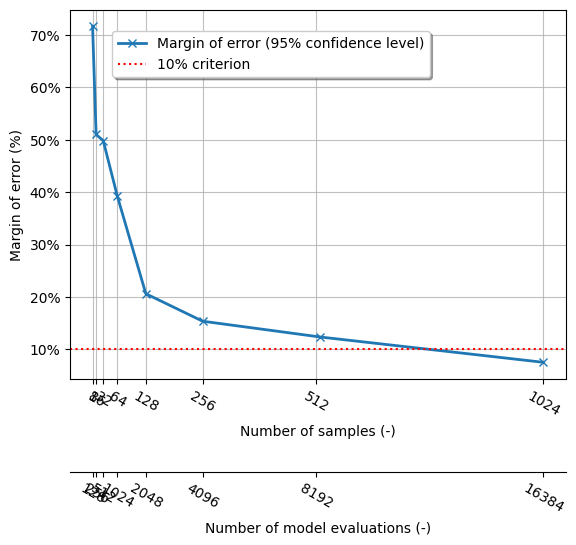

In [12]:
# 95% CONFIDENCE INTERCAL CONVERGENCE
from fastuav.utils.postprocessing.sensitivity_analysis.doe_convergence_plot import sobol_index_error

# Plot margin of error corresponding to 95% confidence interval as a function of number of samples
fig, ax = sobol_index_error(n_array, ST_array, ST_conf_array, d, second_order)